<a href="https://colab.research.google.com/github/KimberlySalazarB/Proyecto_Final_Comunicacion/blob/main/Copia_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-image matplotlib numpy gdown

In [ ]:
#@title Helper

def mostrar(folder, figsize=(15, 9), grid = (4,4)):
  #https://stackoverflow.com/questions/60443761/displaying-random-images-from-multiple-folders-using-python
  images = []
  for image in os.listdir(folder):
    images.append(os.path.join(folder, image))

  plt.figure(1, figsize=figsize)
  plt.axis('off')
  n = 0
  for i in range(grid[0]*grid[1]):
    n += 1
    random_img = random.choice(images)
    imgs = imread(random_img)
    plt.subplot(*grid, n)
    plt.axis('off')
    plt.imshow(imgs)

  plt.show()

In [ ]:
!wget  /content/scaled_imagen.zip

/content/scaled_imagen.zip: Scheme missing.


In [ ]:
!wget  /content/scaled_imagen.zip.zip

/content/scaled_imagen.zip.zip: Scheme missing.


#COMPRIMIDO

In [ ]:
!unzip -qq "/content/scaled_imagen .zip"

In [ ]:
print('scaled_imagen')

scaled_imagen


Descomprimir: Máscaras

In [ ]:
!unzip -qq "scaled_mascaras.zip"

In [ ]:
print('scaled_mascaras.zip')

scaled_mascaras.zip


In [ ]:
!cd scaled_mascaras; for file in *.jpg; do mv "$file" "${file%.jpg}_mask.jpg"; done

#U-Net


In [ ]:
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
from torch.utils.data import DataLoader, random_split
from torch import optim
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

In [ ]:
#@title U-net

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
#@title Dataset

class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]


    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + self.mask_suffix + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }


In [ ]:
#@title Evaluación
def eval_net(net, loader, device):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    n_val = len(loader)  # the number of batch
    tot = 0


    for batch in loader:
      imgs, true_masks = batch['image'], batch['mask']
      imgs = imgs.to(device=device, dtype=torch.float32)
      true_masks = true_masks.to(device=device, dtype=mask_type)

      with torch.no_grad():
        mask_pred = net(imgs)

      if net.n_classes > 1:
        tot += F.cross_entropy(mask_pred, true_masks).item()
      else:
        pred = torch.sigmoid(mask_pred)
        pred = (pred > 0.5).float()
        #cambios
        tot += dice_coeff(pred, true_masks).mean().item()

    net.train()
    return tot / n_val


class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        #self.inter = torch.dot(input.view(-1), target.view(-1))
        #cambios
        self.inter = torch.matmul(input.flatten(-1), target.flatten(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

### **Entrenamiento**

In [ ]:
#@title Parámetros
img_scale = 1.0
val_percent = 0.3
batch_size = 64
num_workers = 2
lr = 0.0001
epochs = 100
dir_img = 'scaled_imagen/'
dir_mask = 'scaled_mascaras/'
device = torch.device('cuda')
criterion = nn.BCEWithLogitsLoss() #si es multiclase, usar nn.CrossEntropyLoss()

In [ ]:
dataset = BasicDataset(dir_img, dir_mask, img_scale, mask_suffix='_mask')
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loade = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=True)
net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
global_step = 0

In [ ]:
lista_train=[]
lista_val=[]

In [ ]:
for epoch in range(epochs):
  net.train()
  epoch_loss = 0
  for batch in train_loade:
    imgs = batch['image']
    imgs = imgs.to(device=device, dtype=torch.float32)
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    true_masks = batch['mask'][:,0:1]
    true_masks = true_masks.to(device=device, dtype=mask_type)
    masks_pred = net(imgs)
    loss = criterion(masks_pred, true_masks)
    epoch_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), 0.1)
    optimizer.step()
    global_step += 1
    if global_step % 10 == 0:
      print("Iter {}".format(global_step))
  val_score = eval_net(net, val_loader, device)
  scheduler.step(val_score)
  print("Train Loss {}".format(epoch_loss))
  lista_train.append(np.mean(epoch_loss))
  print("Val Score {}".format(val_score))
  lista_val.append(np.mean(val_score))

Iter 10
Train Loss 6.308555364608765
Val Score 0.0007593145564896986
Iter 20
Train Loss 5.085869610309601
Val Score 0.0005002645120839588
Iter 30
Train Loss 4.5540288388729095
Val Score 0.0005419521767180413
Iter 40
Train Loss 4.30352458357811
Val Score 0.008248310172348283
Iter 50
Train Loss 4.116953045129776
Val Score 0.004430103290360421
Iter 60
Train Loss 3.9726532995700836
Val Score 0.004337757745815907
Iter 70
Train Loss 3.774625062942505
Val Score 0.00437435440835543
Iter 80
Train Loss 3.707529067993164
Val Score 0.004177969014563132
Iter 90
Train Loss 3.610388606786728
Val Score 0.004152095109020593
Iter 100
Iter 110
Train Loss 3.5379745066165924
Val Score 0.004133855196414515
Iter 120
Train Loss 3.520077884197235
Val Score 0.00417468132218346
Iter 130
Train Loss 3.5077169239521027
Val Score 0.004184908466413617
Iter 140
Train Loss 3.4850447475910187
Val Score 0.004188432511000428
Iter 150
Train Loss 3.4670808613300323
Val Score 0.004188740502286237
Iter 160
Train Loss 3.487771

**Graficas**

**Curva de entrenamineto**

**Metricas**

In [ ]:
import pandas as pd


[]

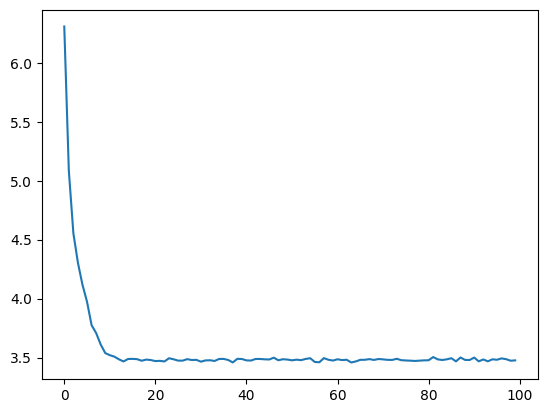

In [ ]:
s=pd.Series(lista_train).plot()
s.plot(xlabel='Eje X', ylabel='Eje Y')

<Axes: >

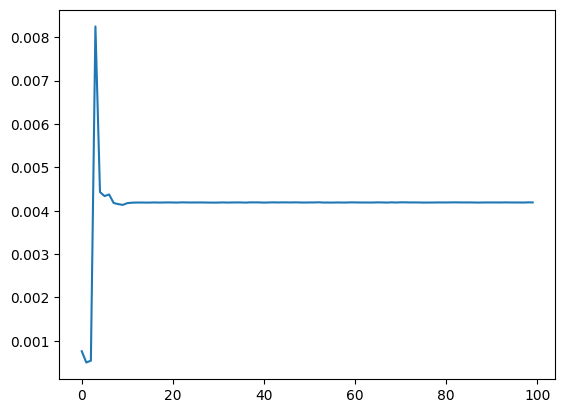

In [ ]:
pd.Series(lista_val).plot()

In [ ]:
print(n_val, "ejemplos de validación")

294 ejemplos de validación


**th=umbral**

In [ ]:
# Definir una lista de valores de umbral para probar
thresholds = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]

# Crear una lista para almacenar el coeficiente de Sørensen-Dice promedio para cada valor de umbral
sorensen_dice_coefficients = []

# Recorrer todos los valores de umbral
for th in thresholds:
    # Crear una lista para almacenar el coeficiente de Sørensen-Dice para cada imagen en el conjunto de validación
    sorensen_dice_coefficients_per_image = []

    # Recorrer todas las imágenes en el conjunto de datos de validación
    for i in range(n_val):
        # Obtener la imagen y la máscara verdadera
        im = val[i]['image']
        mask_to_show = val[i]['mask'][0]

        # Obtener la máscara predicha
        net.eval()
        with torch.no_grad():
            predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]

        # Convertir las máscaras predicha y verdadera en matrices binarias utilizando el valor de umbral actual
        predicted_mask_binary = (predicted_mask > th).astype(int)
        mask_to_show_binary = mask_to_show.numpy().astype(int)

        # Calcular la intersección y la unión de las dos máscaras
        intersection = np.logical_and(predicted_mask_binary, mask_to_show_binary)
        union = np.logical_or(predicted_mask_binary, mask_to_show_binary)

        # Calcular el coeficiente de Sørensen-Dice para esta imagen
        sorensen_dice_coefficient = 2 * intersection.sum() / (predicted_mask_binary.sum() + mask_to_show_binary.sum() + 1e-6)


        # Agregar el coeficiente de Sørensen-Dice a la lista
        sorensen_dice_coefficients_per_image.append(sorensen_dice_coefficient)

    # Calcular el coeficiente de Sørensen-Dice promedio para este valor de umbral
    mean_sorensen_dice_coefficient = np.mean(sorensen_dice_coefficients_per_image)

    # Agregar el coeficiente de Sørensen-Dice promedio a la lista
    sorensen_dice_coefficients.append(mean_sorensen_dice_coefficient)

# Encontrar el índice del valor de umbral que maximiza el coeficiente de Sørensen-Dice promedio
best_threshold_index = np.argmax(sorensen_dice_coefficients)

# Obtener el mejor valor de umbral
best_threshold = thresholds[best_threshold_index]

# Imprimir el resultado
print(f'El mejor valor de umbral es: {best_threshold}')


El mejor valor de umbral es: -1


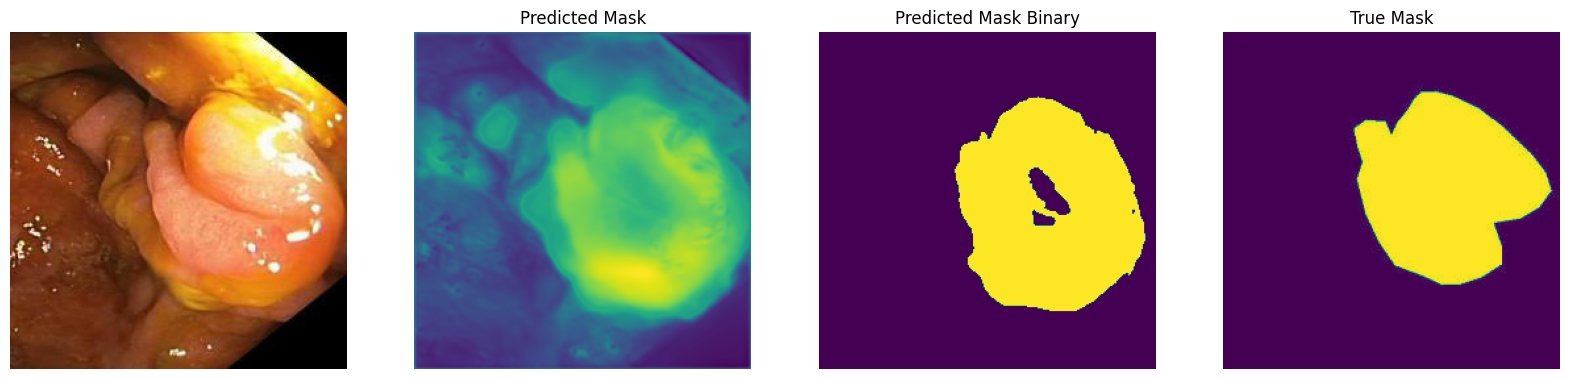

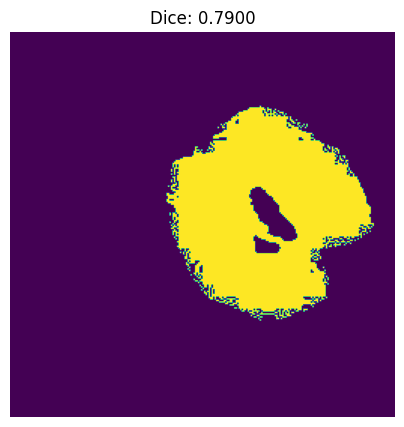

In [ ]:
#@title Evaluación { run: "auto" }
i = 172 #@param {type:"slider", min:0, max:254, step:1}
th = -0.5 #@param {type:"slider", min:-15, max:15, step:0.5}
im = val[i]['image']
im_to_show = im.numpy().transpose((1,2,0))
mask_to_show = val[i]['mask'][0]
plt.figure(figsize=(20,8))
plt.subplot(1,4,  1)
plt.axis('off')
plt.imshow(im_to_show)
plt.subplot(1,4,  2)
net.eval()
with torch.no_grad():
  predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]
plt.subplot(1,4,  2)
plt.imshow(predicted_mask)
plt.axis('off')
plt.title('Predicted Mask')
plt.subplot(1,4,  3)
plt.imshow(predicted_mask>th)
plt.axis('off')
plt.title('Predicted Mask Binary')

plt.subplot(1,4,  4)
plt.imshow(mask_to_show)
plt.axis('off')
plt.title('True Mask')

      # Convertir las máscaras predicha y verdadera en matrices binarias
predicted_mask_binary = (predicted_mask > th).astype(int)
mask_to_show_binary = mask_to_show.numpy().astype(int)

      # Calcular la intersección y la unión de las dos máscaras
intersection = np.logical_and(predicted_mask_binary, mask_to_show_binary)

      # Calcular el coeficiente de Sørensen-Dice para esta imagen
sorensen_dice_coefficient = 2 * intersection.sum() / (predicted_mask_binary.sum() + mask_to_show_binary.sum())

plt.figure(figsize=(5,5))
plt.imshow(intersection)
plt.axis('off')
plt.title(f'Dice: {sorensen_dice_coefficient:.4f}')
plt.show()


**Diff Coef**

In [ ]:
# Establecer el valor del umbral
th = -0.5

# Recorrer todas las imágenes en el conjunto de datos de validación
for i in range(len(val)):
    im = val[i]['image']
    im_to_show = im.numpy().transpose((1,2,0))
    mask_to_show = val[i]['mask'][0]
    plt.figure(figsize=(20,8))

    plt.subplot(1,4,  1)
    plt.axis('off')
    plt.imshow(im_to_show)
    plt.title('Image')

    net.eval()
    with torch.no_grad():
        predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]

    plt.subplot(1,4,  2)
    plt.imshow(predicted_mask)
    plt.axis('off')
    plt.title('Predicted Mask')

    plt.subplot(1,4,  3)
    plt.imshow(predicted_mask>th)
    plt.axis('off')
    plt.title('Predicted Mask Binary')

    plt.subplot(1,4,  4)
    plt.imshow(mask_to_show)
    plt.axis('off')
    plt.title('True Mask')

    # Convertir las máscaras predicha y verdadera en matrices binarias
    predicted_mask_binary = (predicted_mask > th).astype(int)
    mask_to_show_binary = mask_to_show.numpy().astype(int)

    # Calcular la intersección y la unión de las dos máscaras
    intersection = np.logical_and(predicted_mask_binary, mask_to_show_binary)

    # Calcular el coeficiente de Sørensen-Dice para esta imagen
    sorensen_dice_coefficient = 2 * intersection.sum() / (predicted_mask_binary.sum() + mask_to_show_binary.sum())

    plt.figure(figsize=(5,5))
    plt.imshow(intersection)
    plt.axis('off')
    plt.title(f'Dice: {sorensen_dice_coefficient:.4f}')

    plt.show()

In [ ]:
# Establecer el valor del umbral
th = -0.5

# Crear una lista vacía para almacenar los valores del coeficiente de Sørensen-Dice
sorensen_dice_coefficients = []

# Recorrer todas las imágenes en el conjunto de datos de validación desde la imagen 0 hasta la imagen 249
for i in range(n_val):
    # Obtener la imagen y la máscara verdadera
    im = val[i]['image']
    mask_to_show = val[i]['mask'][0]

    # Obtener la máscara predicha
    net.eval()
    with torch.no_grad():
        predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]

    # Convertir las máscaras predicha y verdadera en matrices binarias
    predicted_mask_binary = (predicted_mask > th).astype(int)
    mask_to_show_binary = mask_to_show.numpy().astype(int)

    # Calcular la intersección y la unión de las dos máscaras
    intersection = np.logical_and(predicted_mask_binary, mask_to_show_binary)
    union = np.logical_or(predicted_mask_binary, mask_to_show_binary)

    # Calcular el coeficiente de Sørensen-Dice para esta imagen
    sorensen_dice_coefficient = 2 * intersection.sum() / (predicted_mask_binary.sum() + mask_to_show_binary.sum())

    # Agregar el valor a la lista
    sorensen_dice_coefficients.append(sorensen_dice_coefficient)

    # Imprimir el resultado
    print(f'Coeficiente de Sørensen-Dice para la imagen {i}: {sorensen_dice_coefficient:.4f}')



Coeficiente de Sørensen-Dice para la imagen 0: 0.7412
Coeficiente de Sørensen-Dice para la imagen 1: 0.4792
Coeficiente de Sørensen-Dice para la imagen 2: 0.7213
Coeficiente de Sørensen-Dice para la imagen 3: 0.5814
Coeficiente de Sørensen-Dice para la imagen 4: 0.5199
Coeficiente de Sørensen-Dice para la imagen 5: 0.1278
Coeficiente de Sørensen-Dice para la imagen 6: 0.6139
Coeficiente de Sørensen-Dice para la imagen 7: 0.1407
Coeficiente de Sørensen-Dice para la imagen 8: 0.3842
Coeficiente de Sørensen-Dice para la imagen 9: 0.0000
Coeficiente de Sørensen-Dice para la imagen 10: 0.6339
Coeficiente de Sørensen-Dice para la imagen 11: 0.3015
Coeficiente de Sørensen-Dice para la imagen 12: 0.1707
Coeficiente de Sørensen-Dice para la imagen 13: 0.6307
Coeficiente de Sørensen-Dice para la imagen 14: 0.8155
Coeficiente de Sørensen-Dice para la imagen 15: 0.0899
Coeficiente de Sørensen-Dice para la imagen 16: 0.0869
Coeficiente de Sørensen-Dice para la imagen 17: 0.8305
Coeficiente de Søren

<ipython-input-37-ff30c7fda83f>:27: RuntimeWarning: invalid value encountered in long_scalars
  sorensen_dice_coefficient = 2 * intersection.sum() / (predicted_mask_binary.sum() + mask_to_show_binary.sum())


Coeficiente de Sørensen-Dice para la imagen 81: 0.8035
Coeficiente de Sørensen-Dice para la imagen 82: 0.5854
Coeficiente de Sørensen-Dice para la imagen 83: 0.7260
Coeficiente de Sørensen-Dice para la imagen 84: 0.2201
Coeficiente de Sørensen-Dice para la imagen 85: 0.2582
Coeficiente de Sørensen-Dice para la imagen 86: 0.2610
Coeficiente de Sørensen-Dice para la imagen 87: 0.1774
Coeficiente de Sørensen-Dice para la imagen 88: 0.4662
Coeficiente de Sørensen-Dice para la imagen 89: 0.7377
Coeficiente de Sørensen-Dice para la imagen 90: 0.2124
Coeficiente de Sørensen-Dice para la imagen 91: 0.6703
Coeficiente de Sørensen-Dice para la imagen 92: 0.0000
Coeficiente de Sørensen-Dice para la imagen 93: 0.3926
Coeficiente de Sørensen-Dice para la imagen 94: 0.5938
Coeficiente de Sørensen-Dice para la imagen 95: 0.8314
Coeficiente de Sørensen-Dice para la imagen 96: 0.9165
Coeficiente de Sørensen-Dice para la imagen 97: 0.7709
Coeficiente de Sørensen-Dice para la imagen 98: 0.0000
Coeficient

In [ ]:
print(sorensen_dice_coefficients)

[0.7412208343153429, 0.4792381539885106, 0.7213138318898911, 0.5813500784929356, 0.5198653691373382, 0.12783919597989948, 0.6138892967258845, 0.14070577657900651, 0.38419800802735243, 0.0, 0.6339126559714795, 0.3014887114265996, 0.17069397770309916, 0.6306938926360528, 0.8155497722836695, 0.08992269089922691, 0.08693171010081796, 0.8305489260143198, 0.4881088280060883, 0.0, 0.8948407846972746, 0.6543284134548651, 0.32427944490570515, 0.5185469079361603, 0.5652212207510056, 0.7946874527016801, 0.3885118357887767, 0.0, 0.8046568102278409, 0.7172733138497742, 0.0, 0.8558790546995058, 0.8102629078238834, 0.6611053180396246, 0.7854996243425996, 0.025371908369079127, 0.15587899543378994, 0.42690582959641254, 0.8074551185418665, 0.20228747012632298, 0.5007999534572534, 0.8242432728885155, 0.0, 0.9077251387110542, 0.8054437416139544, 0.357860004713646, 0.7983819919408377, 0.6898395721925134, 0.8492940976356523, 0.0014139271827500884, 0.8641914481787788, 0.8871695680206318, 0.458245466048081, 0

In [ ]:
import pandas as pd
sorensen_dice_coefficients_series = pd.Series(sorensen_dice_coefficients)
sorensen_dice_coefficients_summary = sorensen_dice_coefficients_series.describe()
print(sorensen_dice_coefficients_summary)


count    293.000000
mean       0.479690
std        0.305887
min        0.000000
25%        0.220066
50%        0.537410
75%        0.741221
max        0.927932
dtype: float64


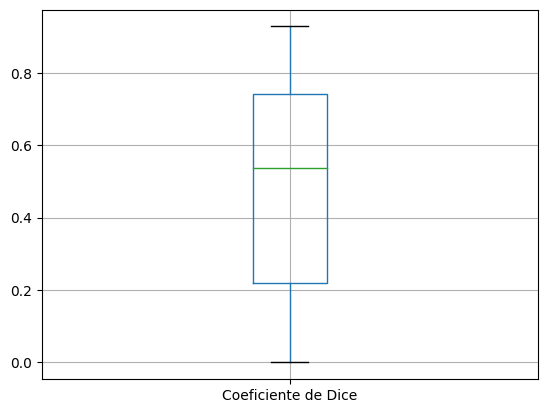

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Crea un DataFrame de Pandas con tus datos
df = pd.DataFrame(sorensen_dice_coefficients, columns=['Coeficiente de Dice'])

# Crea un diagrama de caja y bigotes usando el método boxplot de Pandas
df.boxplot(column=['Coeficiente de Dice'])

# Muestra el gráfico
plt.show()


**IOU**

Text(0.5, 1.0, 'IoU: 0.6529')

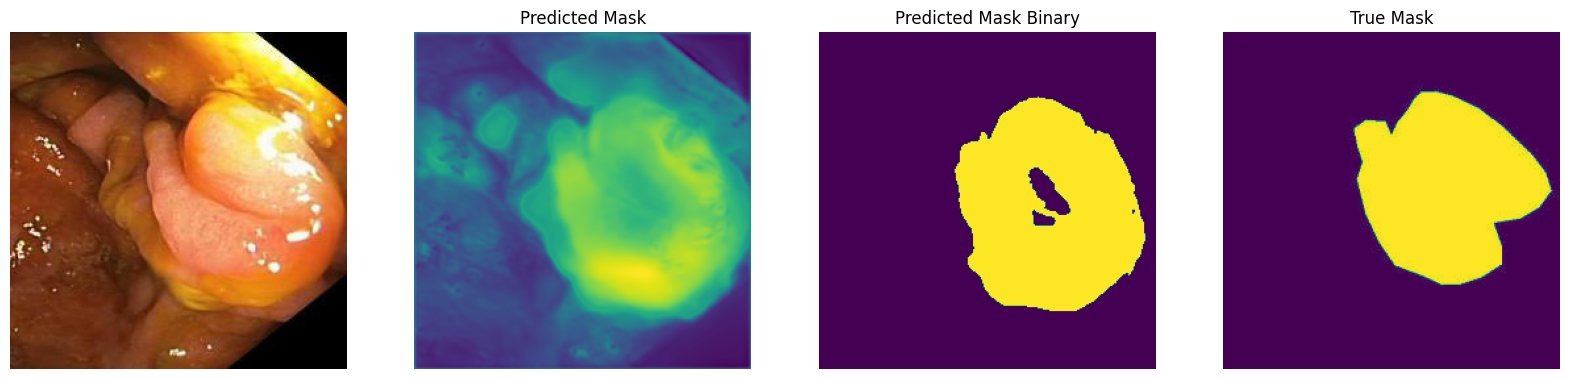

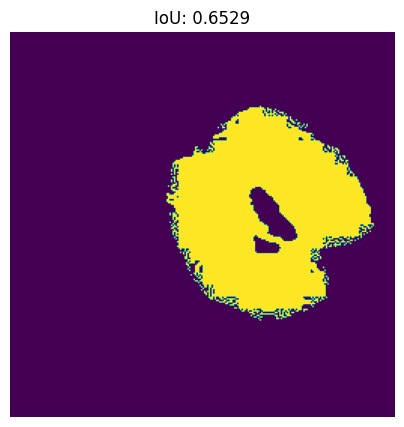

In [ ]:
#@title Evaluación { run: "auto" }
i = 172 #@param {type:"slider", min:0, max:254, step:1}
th = -0.5 #@param {type:"slider", min:-15, max:15, step:0.5}
im = val[i]['image']
im_to_show = im.numpy().transpose((1,2,0))
mask_to_show = val[i]['mask'][0]
plt.figure(figsize=(20,8))
plt.subplot(1,4,  1)
plt.axis('off')
plt.imshow(im_to_show)
plt.subplot(1,4,  2)
net.eval()
with torch.no_grad():
  predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]
plt.subplot(1,4,  2)
plt.imshow(predicted_mask)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,  3)
plt.imshow(predicted_mask>th)
plt.axis('off')
plt.title('Predicted Mask Binary')

plt.subplot(1,4,  4)
plt.imshow(mask_to_show)
plt.axis('off')
plt.title('True Mask')

    # Convertir las máscaras predicha y verdadera en matrices binarias
predicted_mask_binary = (predicted_mask > th).astype(int)
mask_to_show_binary = mask_to_show.numpy().astype(int)

    # Calcular la intersección y la unión de las dos máscaras
intersection = np.logical_and(predicted_mask_binary, mask_to_show_binary)
union = np.logical_or(predicted_mask_binary, mask_to_show_binary)

    # Calcular el coeficiente de Jaccard (IoU) para esta imagen
jaccard_coefficient = intersection.sum() / union.sum()

plt.figure(figsize=(5,5))
plt.imshow(intersection)
plt.axis('off')
plt.title(f'IoU: {jaccard_coefficient:.4f}')

In [ ]:
# Establecer el valor del umbral
th = -0.5
jaccard_coefficients= []
# Recorrer todas las imágenes en el conjunto de datos de validación
for i in range(len(val)):
    im = val[i]['image']
    mask_to_show = val[i]['mask'][0]

    net.eval()
    with torch.no_grad():
        predicted_mask = net(im.unsqueeze(0).to(device)).cpu().numpy()[0, 0]

    # Convertir las máscaras predicha y verdadera en matrices binarias
    predicted_mask_binary = (predicted_mask > th).astype(int)
    mask_to_show_binary = mask_to_show.numpy().astype(int)

    # Calcular la intersección y la unión de las dos máscaras
    intersection = np.logical_and(predicted_mask_binary, mask_to_show_binary)
    union = np.logical_or(predicted_mask_binary, mask_to_show_binary)

    # Calcular el coeficiente de Jaccard (IoU) para esta imagen
    jaccard_coefficient = intersection.sum() / union.sum()
    jaccard_coefficients.append(jaccard_coefficient)
    # Imprimir el resultado
    print(f'Coeficiente de Jaccard (IoU) para la imagen {i}: {jaccard_coefficient:.4f}')

Coeficiente de Jaccard (IoU) para la imagen 0: 0.5888
Coeficiente de Jaccard (IoU) para la imagen 1: 0.3151
Coeficiente de Jaccard (IoU) para la imagen 2: 0.5641
Coeficiente de Jaccard (IoU) para la imagen 3: 0.4098
Coeficiente de Jaccard (IoU) para la imagen 4: 0.3512
Coeficiente de Jaccard (IoU) para la imagen 5: 0.0683
Coeficiente de Jaccard (IoU) para la imagen 6: 0.4429
Coeficiente de Jaccard (IoU) para la imagen 7: 0.0757
Coeficiente de Jaccard (IoU) para la imagen 8: 0.2378
Coeficiente de Jaccard (IoU) para la imagen 9: 0.0000
Coeficiente de Jaccard (IoU) para la imagen 10: 0.4640
Coeficiente de Jaccard (IoU) para la imagen 11: 0.1775
Coeficiente de Jaccard (IoU) para la imagen 12: 0.0933
Coeficiente de Jaccard (IoU) para la imagen 13: 0.4606
Coeficiente de Jaccard (IoU) para la imagen 14: 0.6885
Coeficiente de Jaccard (IoU) para la imagen 15: 0.0471
Coeficiente de Jaccard (IoU) para la imagen 16: 0.0454
Coeficiente de Jaccard (IoU) para la imagen 17: 0.7102
Coeficiente de Jacca

<ipython-input-44-f74008638215>:22: RuntimeWarning: invalid value encountered in long_scalars
  jaccard_coefficient = intersection.sum() / union.sum()


Coeficiente de Jaccard (IoU) para la imagen 82: 0.4138
Coeficiente de Jaccard (IoU) para la imagen 83: 0.5699
Coeficiente de Jaccard (IoU) para la imagen 84: 0.1236
Coeficiente de Jaccard (IoU) para la imagen 85: 0.1482
Coeficiente de Jaccard (IoU) para la imagen 86: 0.1501
Coeficiente de Jaccard (IoU) para la imagen 87: 0.0973
Coeficiente de Jaccard (IoU) para la imagen 88: 0.3039
Coeficiente de Jaccard (IoU) para la imagen 89: 0.5844
Coeficiente de Jaccard (IoU) para la imagen 90: 0.1188
Coeficiente de Jaccard (IoU) para la imagen 91: 0.5041
Coeficiente de Jaccard (IoU) para la imagen 92: 0.0000
Coeficiente de Jaccard (IoU) para la imagen 93: 0.2443
Coeficiente de Jaccard (IoU) para la imagen 94: 0.4223
Coeficiente de Jaccard (IoU) para la imagen 95: 0.7115
Coeficiente de Jaccard (IoU) para la imagen 96: 0.8459
Coeficiente de Jaccard (IoU) para la imagen 97: 0.6272
Coeficiente de Jaccard (IoU) para la imagen 98: 0.0000
Coeficiente de Jaccard (IoU) para la imagen 99: 0.3723
Coeficient

In [ ]:
print(jaccard_coefficients)

[0.5888410410035574, 0.31513031132745156, 0.5641054465741105, 0.4097910764872521, 0.3512284344258243, 0.06828430319948464, 0.4428861960850775, 0.0756769825918762, 0.2377754266525599, 0.0, 0.4640352307943239, 0.1775017413512886, 0.09331078322738671, 0.46059379217273955, 0.6885471024443834, 0.04707803734999645, 0.04544098637764741, 0.710204081632653, 0.3228465362109105, 0.0, 0.8096939991150142, 0.4862467335992298, 0.19351642129105323, 0.35002587035257593, 0.3939431143851033, 0.6593206504677591, 0.24108885464817667, 0.0, 0.67315965583174, 0.559178601017872, 0.0, 0.7480669401386721, 0.6810436634717785, 0.4937694704049844, 0.6467677080111351, 0.012848955444629322, 0.08452753102850599, 0.27137970353477764, 0.6770857274189841, 0.11252492640774855, 0.33404478249058944, 0.7010321556173085, 0.0, 0.8310409502969678, 0.6742618741976893, 0.21792295768987888, 0.6644224592059617, 0.5265306122448979, 0.7380635624538063, 0.0007074637424831977, 0.7608601350932639, 0.7972190034762456, 0.29722336205717415

In [ ]:
import pandas as pd
jaccard_coefficient_series = pd.Series(jaccard_coefficients)
jaccard_coefficient_summary = jaccard_coefficient_series.describe()
print(jaccard_coefficient_summary)

count    293.000000
mean       0.368456
std        0.267665
min        0.000000
25%        0.123637
50%        0.367437
75%        0.588841
max        0.865554
dtype: float64


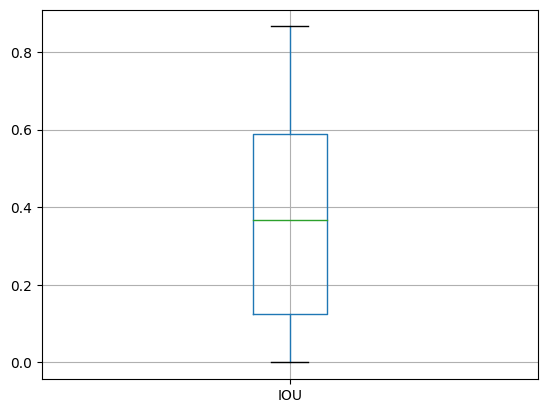

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Crea un DataFrame de Pandas con tus datos
df = pd.DataFrame(jaccard_coefficients, columns=['IOU'])

# Crea un diagrama de caja y bigotes usando el método boxplot de Pandas
df.boxplot(column=['IOU'])

# Mostrar el gráfico
plt.show()

<Axes: ylabel='Frequency'>

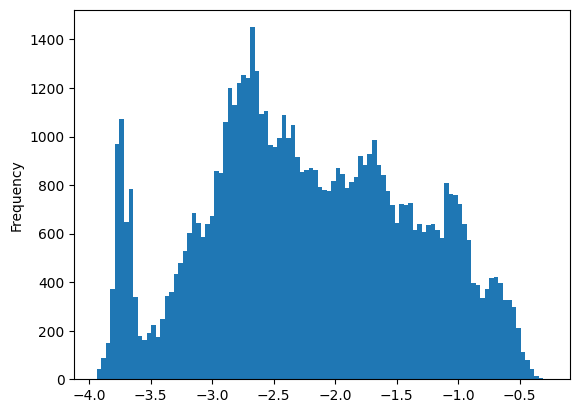

In [ ]:
pd.Series(predicted_mask.ravel()).plot.hist(bins=100)